<a href="https://colab.research.google.com/github/bnarath/TF_Developer/blob/main/Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes


### What is transfer learning ?
Using another model's weight to use in our model and learn further

### Main benefits
- Can leverage an established model's learning
- Can leverage another model's architecture that is trained on similar data


### GPU Check
- !nvidia-smi
  - Tesla is Nvidia's line of GPGPU products


### Data & Prep
- We have only 75 images of each 10 categories for train and 250 images of each 10 categories for test

```
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                  target_size=IMAGE_SHAPE,
                                  batch_size=BATCH_SIZE,
                                  class_mode='categorical')

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                  target_size=IMAGE_SHAPE,
                                  batch_size=BATCH_SIZE,
                                  class_mode='categorical')
```

### Creating models using Transfer Learning

- TF Hub [here](https://tfhub.dev/)

  - Resnet and Efficientnet are good image classification models
  - ResNetV2 - a state of the art computer vision model architecture from 2016.
  - EfficientNet - a state of the art computer vision architecture from 2019.

- State of the art means that at some point, both of these models have achieved the benchmarking results on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.

- Benchmarking Datasets
  - Imagenet
  - CIFAR-100
  - Flowers

- We are using Efficentnet/b0/feature_vector and Resnet_v2_50/feature_vector
  - https://tfhub.dev/google/efficientnet/b0/feature-vector/1
  - https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

- Types of transfer learning
  1. As Is
  1. Feature Extraction (fine tuning only top dense layer)
  1. Fine Tuning (fine tuning many layers)

  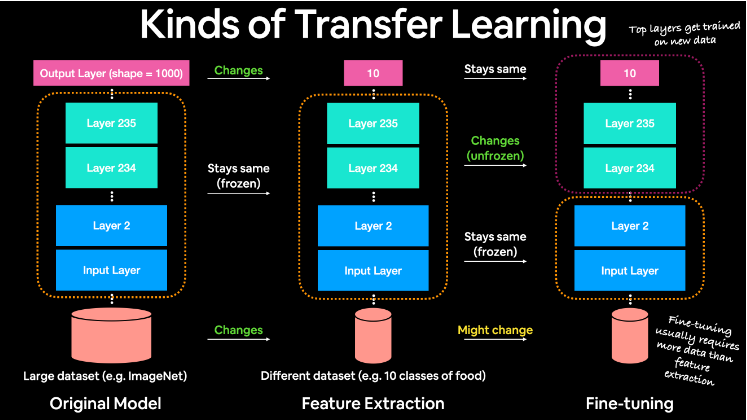



### Model Build, Compile and Fit

```
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10):
  """Takes a TF hub url and build a keras sequential model

  Args:
    model_url: TF hub model url
    num_classes: #of to be trained images

  Returns:
    Uncompiled keras sequential model 
  """
  feature_extraction_layer = hub.KerasLayer(handle=model_url,
                 trainable=False,
                 name="feature_extraction_layer",
                 input_shape=(224,224,3)
                 )
  
  model = tf.keras.Sequential(
      [feature_extraction_layer,
       tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")]
  )
  return model

  
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
resnet_model = create_model(resnet_url, num_classes=10)

resnet_model.summary()


resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

resnet_history=resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet_v2_50")],
                 validation_data=test_data,
                 validation_steps=len(test_data))
```


### Plot Performance
```
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))


  #Plot loss
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  
  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

```


### Tensorflow Dev Upload and view tensorboard
```
!tensorboard dev upload --logdir tensorflow_hub/ \
                        --name "EfficientNetB0 vs. ResNet50V2 vs MobileNetV2100" \
                        --description "Comparing two different TF Hub feature extraction models architectures using 10% of training data" \
                        --one_shot


!tensorboard dev delete --experiment_id AWikF73bRlWZzKsGDDf7VA


!tensorboard dev list
```

In [44]:
!nvidia-smi

Wed Feb  8 22:55:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   9014MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download, Extract, Inspect

- We have only 75 images of each 10 categories for train and 250 images of each 10 categories for test

In [45]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-08 22:55:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  24.0MB/s    in 7.6s    

2023-02-08 22:55:19 (21.2 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [46]:
import zipfile
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### Check how many files?

In [47]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
     

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Create dataloaders

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                  target_size=IMAGE_SHAPE,
                                  batch_size=BATCH_SIZE,
                                  class_mode='categorical')

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                  target_size=IMAGE_SHAPE,
                                  batch_size=BATCH_SIZE,
                                  class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

- Callbacks ?
  - Extra functionality to add before and after training

- Popular callbacks
  - Experiment tracking with tensorboard (log the performance of multiple models, track them visually)

  - Model checkpoint - Save weights while training so that later the model can be stopped and resumed

  - Early stopping - Leave model training for an arbitrarily long time and let the model stop when it ceases to see the improvement

- How to access ?
  `tf.keras.callbacks.TensorBoard()`
  - It saves model performance to a `log_dir`
  - Logs are recorded every `update_freq=#of_epochs`
    - Logging too frequently slows down the model training



In [50]:
from datetime import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensorboard_callback


# Creating models using Tensorflow Hub

- TF Hub [here](https://tfhub.dev/)

  - Resnet and Efficientnet are good image classification models
  - ResNetV2 - a state of the art computer vision model architecture from 2016.
  - EfficientNet - a state of the art computer vision architecture from 2019.

- State of the art means that at some point, both of these models have achieved the benchmarking results on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.

- Benchmarking Datasets
  - Imagenet
  - CIFAR-100
  - Flowers

- We are using Efficentnet/b0/feature_vector and Resnet_v2_50/feature_vector
  - https://tfhub.dev/google/efficientnet/b0/feature-vector/1
  - https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

- Types of transfer learning
  1. As Is
  1. Feature Extraction (fine tuning only top dense layer)
  1. Fine Tuning (fine tuning many layers)

  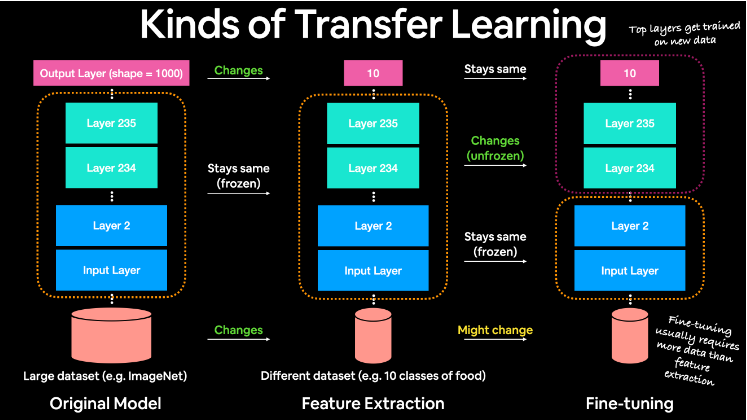


In [51]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

## Resnet

In [52]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [53]:
def create_model(model_url, num_classes=10):
  """Takes a TF hub url and build a keras sequential model

  Args:
    model_url: TF hub model url
    num_classes: #of to be trained images

  Returns:
    Uncompiled keras sequential model 
  """
  feature_extraction_layer = hub.KerasLayer(handle=model_url,
                 trainable=False,
                 name="feature_extraction_layer",
                 input_shape=(224,224,3)
                 )
  
  model = tf.keras.Sequential(
      [feature_extraction_layer,
       tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")]
  )
  return model

  



In [54]:
resnet_model = create_model(resnet_url, num_classes=10)

resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [55]:
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)



In [56]:
resnet_history=resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet_v2_50")],
                 validation_data=test_data,
                 validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 30s 907ms/step - loss: 1.9628 - accuracy: 0.3480 - val_loss: 1.1936 - val_accuracy: 0.6344
Epoch 2/5
24/24 [==============================] - 23s 1s/step - loss: 0.9216 - accuracy: 0.7320 - val_loss: 0.8207 - val_accuracy: 0.7384
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.6242 - accuracy: 0.8227 - val_loss: 0.7468 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.4835 - accuracy: 0.8680 - val_loss: 0.7130 - val_accuracy: 0.7568
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.3896 - accuracy: 0.9067 - val_loss: 0.6631 - val_accuracy: 0.7772


## Plot loss curves

In [57]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))


  #Plot loss
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  
  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()



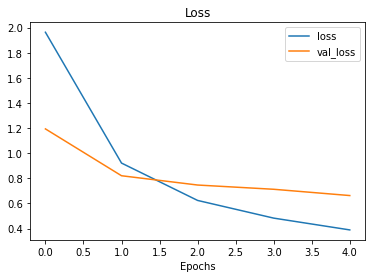

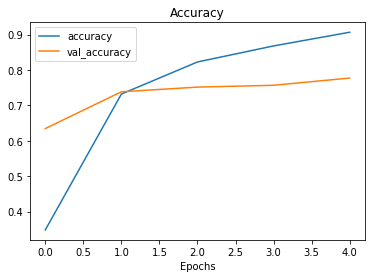

In [58]:
plot_loss_curves(resnet_history)

In [59]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [60]:
efficientnet_model = create_model(efficientnet_url, num_classes=10)

In [61]:
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

efficientnet_history=efficientnet_model.fit(train_data,
                       validation_data=test_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnet_b0")])

Epoch 1/5
24/24 [==============================] - 32s 935ms/step - loss: 1.8235 - accuracy: 0.4560 - val_loss: 1.2745 - val_accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 22s 949ms/step - loss: 1.0492 - accuracy: 0.7760 - val_loss: 0.8566 - val_accuracy: 0.8288
Epoch 3/5
24/24 [==============================] - 16s 702ms/step - loss: 0.7441 - accuracy: 0.8427 - val_loss: 0.6889 - val_accuracy: 0.8516
Epoch 4/5
24/24 [==============================] - 18s 764ms/step - loss: 0.5970 - accuracy: 0.8653 - val_loss: 0.6067 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 18s 753ms/step - loss: 0.5070 - accuracy: 0.8920 - val_loss: 0.5517 - val_accuracy: 0.8644


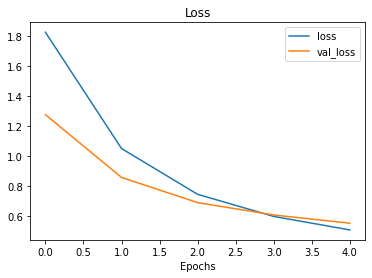

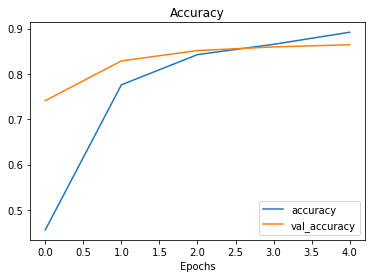

In [62]:
plot_loss_curves(efficientnet_history)

In [63]:
efficientnet_model.evaluate(test_data), resnet_model.evaluate(test_data)

79/79 [==============================] - 16s 199ms/step - loss: 0.6631 - accuracy: 0.7772


([0.5516816973686218, 0.8644000291824341],
 [0.6630659699440002, 0.7771999835968018])

# Upload to [tensorflow dev](https://tensorboard.dev/)
### (A managed TensorBoard experience that lets you upload and share your ML experiment results with anyone)

## Steps
1. Prepare your TensorBoard logs
1. Upload the logs (This TensorBoard will be visible to everyone. Do not upload sensitive data.)
1. View your experiment on TensorBoard.dev.
1. Sign in to TensorBoard.dev.
1. --one_shot (do not monitor log dir)
1. Tensorboard can also be integrated into weights and biases

In [64]:
! tensorboard dev upload --logdir tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction models architectures using 10% of training data" \
    --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/EgkCadnJRQKjjQAmc46lPA/

[2023-02-08T23:00:44] Started scanning logdir.
[2023-02-08T23:00:56] Total uploaded: 120 scalars, 0 tensors, 4 binary objects (11.3 MB)
[2023-02-08T23:00:56] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/EgkCadnJRQKjjQAmc46lPA/


In [65]:
!tensorboard dev list

https://tensorboard.dev/experiment/EgkCadnJRQKjjQAmc46lPA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training data
	Id                   EgkCadnJRQKjjQAmc46lPA
	Created              2023-02-08 23:00:44 (17 seconds ago)
	Updated              2023-02-08 23:00:56 (5 seconds ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  11843421
https://tensorboard.dev/experiment/Aaj1QbVpSl6pW75IYP2DNA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training data
	Id                   Aaj1QbVpSl6pW75IYP2DNA
	Created              2023-02-08 22:06:11 (54 minutes ago)
	Updated              2023-02-08 22:06:16 (54 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor byt

In [66]:
!tensorboard dev delete --experiment_id l6LeiQm3Q2WZMyOPq3HkCw

No such experiment l6LeiQm3Q2WZMyOPq3HkCw. Either it never existed or it has already been deleted.



In [67]:
!tensorboard dev list

https://tensorboard.dev/experiment/EgkCadnJRQKjjQAmc46lPA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training data
	Id                   EgkCadnJRQKjjQAmc46lPA
	Created              2023-02-08 23:00:44 (26 seconds ago)
	Updated              2023-02-08 23:00:56 (14 seconds ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  11843421
https://tensorboard.dev/experiment/Aaj1QbVpSl6pW75IYP2DNA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training data
	Id                   Aaj1QbVpSl6pW75IYP2DNA
	Created              2023-02-08 22:06:11 (54 minutes ago)
	Updated              2023-02-08 22:06:16 (54 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor by

## Use MobileNet

In [69]:
# MobileNet V2 100 - 224 feature vector
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"

mobilenet_model = create_model(mobilenet_url, num_classes=10)
mobilenet_model.summary()

mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

mobilenet_history = mobilenet_model.fit(train_data,
                                        validation_data=test_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback("tensorflow_hub", "mobilenet_v2_100")])



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             3540265   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 3,550,285
Trainable params: 10,020
Non-trainable params: 3,540,265
_________________________________________________________________
Epoch 1/5
24/24 [==============================] - 23s 715ms/step - loss: 2.0038 - accuracy: 0.3773 - val_loss: 1.0930 - val_accuracy: 0.6424
Epoch 2/5
24/24 [==============================] - 16s 669ms/step - loss: 0.8702 - accuracy: 0.7040 - val_loss: 0.7766 - val_accuracy: 0.7392
Epoch 3/5
24/24 [==============================] - 16s 698ms/step - loss: 0.5797 - ac

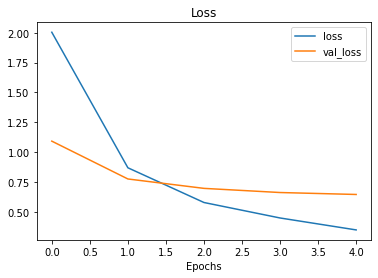

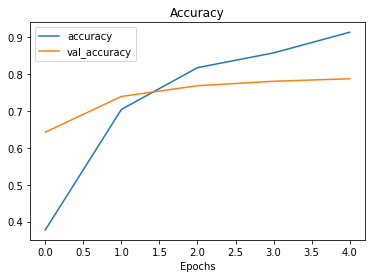

In [70]:
plot_loss_curves(mobilenet_history)

In [72]:
mobilenet_model.evaluate(test_data), efficientnet_model.evaluate(test_data), resnet_model.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.6631 - accuracy: 0.7772


([0.6469660401344299, 0.7871999740600586],
 [0.5516817569732666, 0.8644000291824341],
 [0.663066029548645, 0.7771999835968018])

In [87]:
!tensorboard dev list

https://tensorboard.dev/experiment/AWikF73bRlWZzKsGDDf7VA/
	Name                 EfficientNetB0 vs. ResNet50V2 vs MobileNetV2100
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training data
	Id                   AWikF73bRlWZzKsGDDf7VA
	Created              2023-02-08 23:10:06 (1 minute ago)
	Updated              2023-02-08 23:10:14 (1 minute ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7583360
Total: 1 experiment(s)


In [88]:
# !tensorboard dev delete --experiment_id AWikF73bRlWZzKsGDDf7VA

Deleted experiment AWikF73bRlWZzKsGDDf7VA.


In [86]:
!tensorboard dev upload --logdir tensorflow_hub/ \
                        --name "EfficientNetB0 vs. ResNet50V2 vs MobileNetV2100" \
                        --description "Comparing two different TF Hub feature extraction models architectures using 10% of training data" \
                        --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/AWikF73bRlWZzKsGDDf7VA/

[2023-02-08T23:10:06] Started scanning logdir.
[2023-02-08T23:10:14] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.2 MB)
[2023-02-08T23:10:14] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/AWikF73bRlWZzKsGDDf7VA/
